# Setup

In [1]:
import gc
gc.enable()

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import (
    set_random_seed,
    image_dataset_from_directory,
    load_img,
    img_to_array
)

In [2]:
SEED = 2024
set_random_seed(SEED)

# Loading the data

In [3]:
# train directory will be used for training and validation + overfitting-detection
TRAIN_DIR = '/kaggle/input/animals/animals/train'

# val directory will be used as a replacement for test set
# since inf directory has only 5 images for testing
TEST_DIR = '/kaggle/input/animals/animals/val'

In [4]:
# loading parameters
BATCH_SIZE = 32
IMG_SIZE = 256
VAL_SPLIT = 0.2

**Train, Validation and Test splits**

In [5]:
train_ds = image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',
    label_mode='int',
    validation_split=VAL_SPLIT,
    subset='training',
    image_size=(IMG_SIZE, IMG_SIZE),
    interpolation='lanczos5',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED    
)

class_names = train_ds.class_names
print(f'\nClass names: {class_names}')

Found 13474 files belonging to 5 classes.
Using 10780 files for training.

Class names: ['cat', 'dog', 'elephant', 'horse', 'lion']


In [6]:
val_ds = image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',
    label_mode='int',
    class_names=class_names,
    validation_split=VAL_SPLIT,
    subset='validation',
    image_size=(IMG_SIZE, IMG_SIZE),
    interpolation='lanczos5',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED    
)

Found 13474 files belonging to 5 classes.
Using 2694 files for validation.


In [7]:
test_ds = image_dataset_from_directory(
    TEST_DIR,
    labels='inferred',
    label_mode='int',
    class_names=class_names,
    validation_split=None,
    image_size=(IMG_SIZE, IMG_SIZE),
    interpolation='lanczos5',
    batch_size=1,
    shuffle=False,
    seed=SEED    
)

Found 1497 files belonging to 5 classes.


In [8]:
test_labels = np.concatenate([y for _, y in test_ds], axis=0)

**Visualizing some samples**

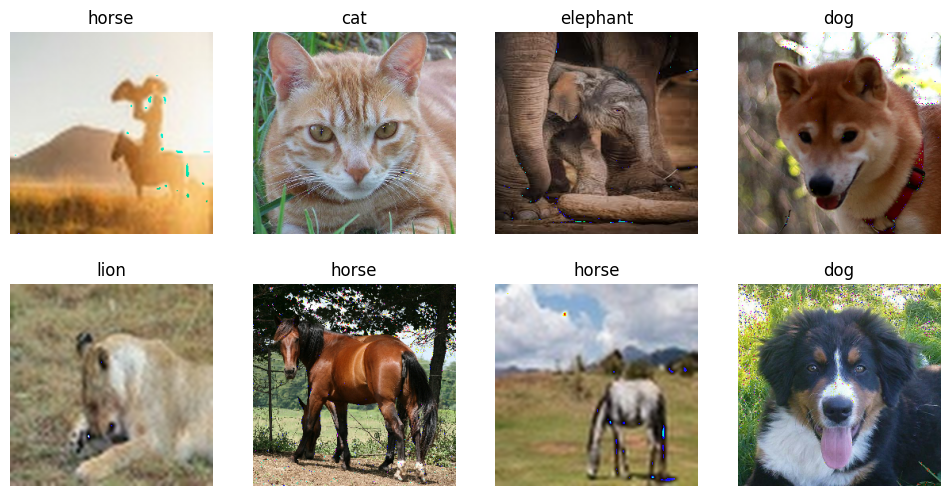

In [9]:
plt.figure(figsize=(12, 6))
for images, labels in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

**Configuring the dataset for performance**

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Modeling

In [11]:
keras.backend.clear_session()

**Model architecture**

In [12]:
num_classes = len(class_names)

data_augmentation = Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.25),
    layers.RandomZoom(0.15)
])

cnn_model = Sequential([
    layers.Rescaling(1./255, input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    data_augmentation,
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

In [13]:
cnn_model.compile(
    optimizer='adam',
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [14]:
cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    16,777,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,817,829 (64.15 MB)

 Trainable params: 16,817,829 (64.15 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# training parameters
MIN_DELTA = 2e-4
PATIENCE = 25
EPOCHS = 200

**Overfitting detection**

In [16]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=MIN_DELTA,
    patience=PATIENCE,
    verbose=0,
    mode='max',
    restore_best_weights=True
)

**Model training**

In [17]:
history = cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=[early_stopping],
    epochs=EPOCHS
)

Epoch 1/200


2024-08-27 11:37:05.994722: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


337/337 ━━━━━━━━━━━━━━━━━━━━ 73s 66ms/step - accuracy: 0.3401 - loss: 1.5115 - val_accuracy: 0.6444 - val_loss: 0.8962
Epoch 2/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.6238 - loss: 0.9420 - val_accuracy: 0.7094 - val_loss: 0.7413
Epoch 3/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.6969 - loss: 0.7488 - val_accuracy: 0.7324 - val_loss: 0.6923
Epoch 4/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.7279 - loss: 0.6918 - val_accuracy: 0.7257 - val_loss: 0.7203
Epoch 5/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.7504 - loss: 0.6378 - val_accuracy: 0.7758 - val_loss: 0.5870
Epoch 6/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.7632 - loss: 0.5966 - val_accuracy: 0.7866 - val_loss: 0.5385
Epoch 7/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.7819 - loss: 0.5630 - val_accuracy: 0.7970 - val_loss: 0.5186
Epoch 8/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.7863 - loss: 0.5542 - val_

**Visualizing training results**

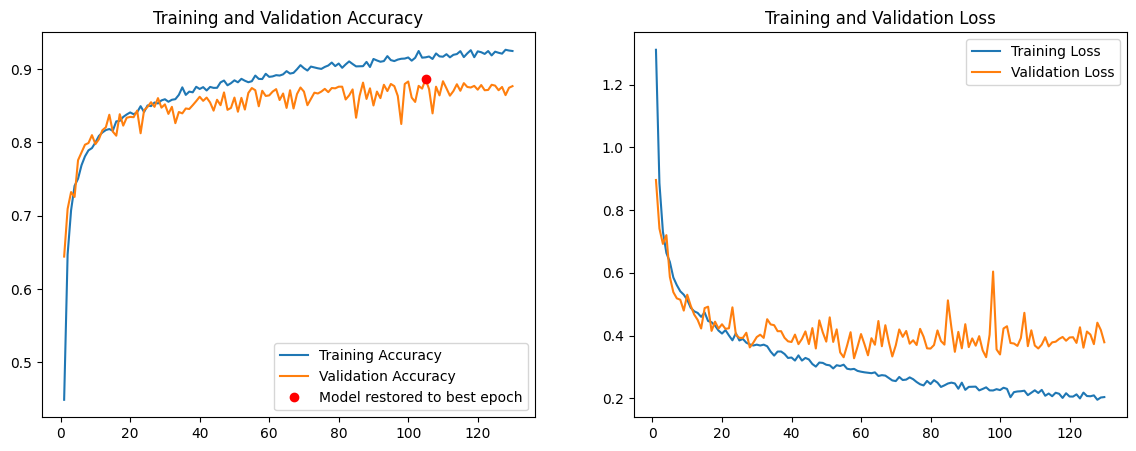

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_run = len(loss)
epochs_range = range(1, epochs_run + 1)
early_stop = epochs_run - PATIENCE
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.plot(early_stop, val_acc[early_stop-1], 'ro', label='Model restored to best epoch')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Evaluating the model on test set

In [19]:
test_loss, test_accuracy = cnn_model.evaluate(x=test_ds, verbose=2)

1497/1497 - 5s - 3ms/step - accuracy: 0.8664 - loss: 0.3858


Accuracy on unseen test set keeps up with training and validation accuracy.

In [20]:
predictions = cnn_model.predict(test_ds)
probabilities = np.max(predictions, axis=1)
predicted_labels = np.argmax(predictions, axis=1)

1497/1497 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


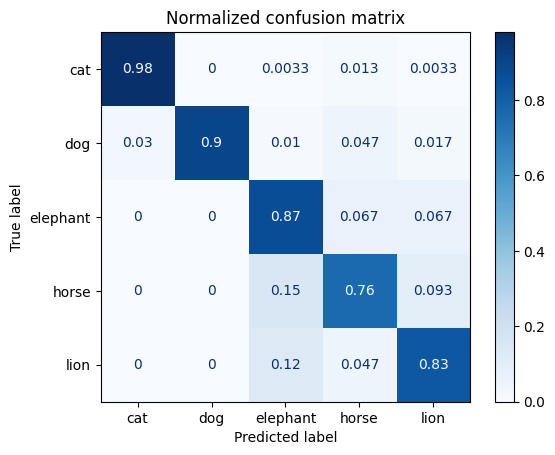

In [21]:
disp = ConfusionMatrixDisplay.from_predictions(
    test_labels, predicted_labels,
    display_labels=class_names,
    cmap=plt.cm.Blues,
    normalize='true')

disp.ax_.set_title('Normalized confusion matrix')
plt.show()

# Inference on new images

In [22]:
def predict_on_image(file_path, model):
    # load image from file path
    img = load_img(file_path, target_size=(IMG_SIZE, IMG_SIZE))
    
    # display image
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')
    
    # convert image to batch for prediction 
    img_batch = tf.expand_dims(img_to_array(img), 0)
    prediction = model.predict(img_batch, verbose=0)
    label = class_names[np.argmax(prediction[0])]
    confidence = np.max(prediction[0])
    print(f'Predicted label: {label} (Confidence: {confidence*100:.2f}%)\n')

Predicted label: lion (Confidence: 98.82%)



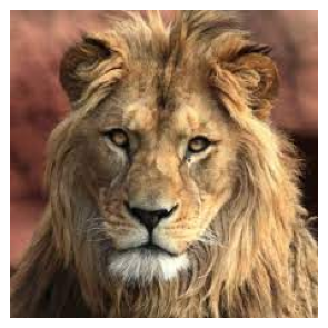

In [23]:
file_path = '/kaggle/input/animals/animals/inf/lion.jpg'
predict_on_image(file_path, cnn_model)

Predicted label: elephant (Confidence: 41.79%)



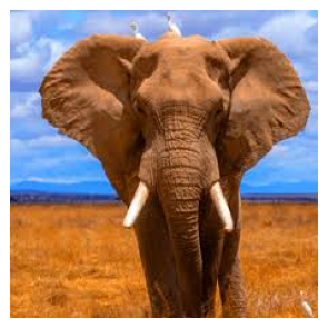

In [24]:
file_path = '/kaggle/input/animals/animals/inf/elephant.jpg'
predict_on_image(file_path, cnn_model)